## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

### Define utils

In [40]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 1]
    image = image[:,:,0]*0.049+0.094
    plt.imshow(torch.clip(image * 255, 0, 255).int(), cmap='gray')
    plt.title(title, fontsize=16)
    plt.axis('off')
    print(image.shape)
    return

def prepare_model(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    print(loss)

    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *1)  # (N, H*W, p*p*1) we have set inchans=1
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()
    


### Load an image

(224, 224)
torch.Size([224, 224])


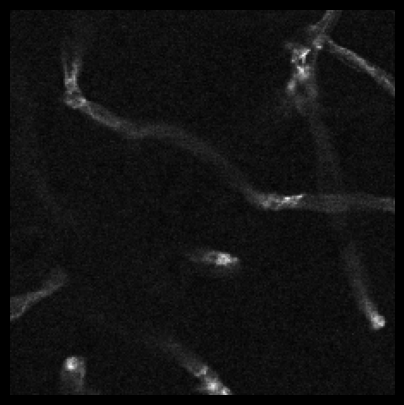

In [41]:
# load an image
import cv2 
import tifffile as tf

path = './data/train/B2_Mark_and_Find_001_Pos004_S001_0_672_448.tiff'
image = tf.imread(path).astype(np.float32)
image = image / 65535.
print(image.shape)
image = (image - 0.094)/0.049

image = cv2.resize(image, (224,224))
image = np.expand_dims(image, axis=0) 
img = image.transpose(1,2,0)

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [42]:
chkpt_dir = './mae/output/checkpoint-399.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:
tensor(0.9202, grad_fn=<DivBackward0>)
torch.Size([224, 224])
torch.Size([224, 224])
torch.Size([224, 224])
torch.Size([224, 224])


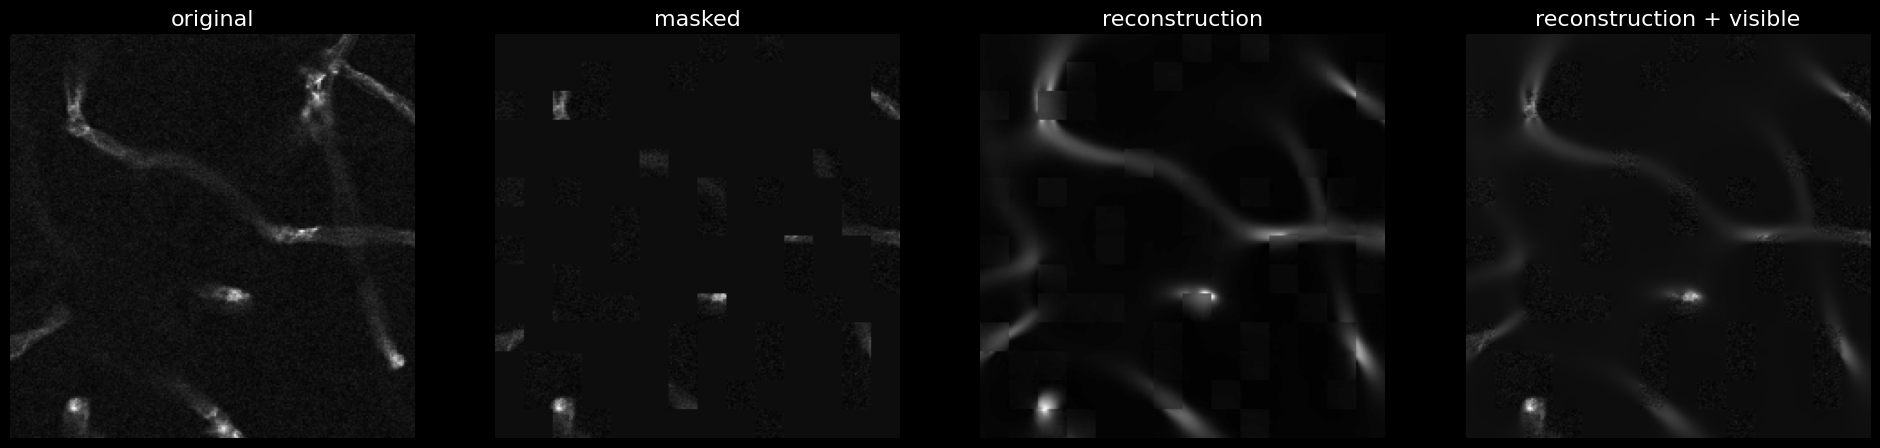

In [43]:
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)